# **Detección de Armas - Open Data**  

📌 [**Información del Dataset**](https://dasci.es/es/transferencia/open-data/deteccion-de-armas/)  

Este proyecto se centra en la aplicación de **Data Augmentation** mediante **Diffusion Models** sobre este **conjunto de datos específico**. Nuestro objetivo es evaluar si estas técnicas pueden mejorar el rendimiento y los resultados en una tarea concreta de detección.

--- 
Este dataset cuenta con múltiples sub-datasets, donde nos encontramos con la siguiente estructura de directorios:

    Knife_classification  License.md             Pistol_detection  Weapons_and_similar_handled_objects/
    Knife_detection       Pistol_classification  README.md         pictures

Debido a las características del problema en concreto, solo trabajaremos con la parte de Object Detection (OD), es decir, las siguientes clases:

    Knife_detection                 
    Pistol_detection 
    Weapons_and_similar_handled_objects/Sohas_weapon-Detection-YOLOv5

Para empezar nos centraremos en:

    Weapons_and_similar_handled_objects/Sohas_weapon-Detection-YOLOv5

In [1]:
data_path = "/mnt/homeGPU/azapata/TFG/datasets/gunsUGR/OD-WeaponDetection-master/Weapons_and_similar_handled_objects/Sohas_weapon-Detection-YOLOv5/obj_train_data"
images_path = "/mnt/homeGPU/azapata/TFG/datasets/gunsUGR/OD-WeaponDetection-master/Weapons_and_similar_handled_objects/Sohas_weapon-Detection-YOLOv5/obj_train_data/images/train"
labels_path = "/mnt/homeGPU/azapata/TFG/datasets/gunsUGR/OD-WeaponDetection-master/Weapons_and_similar_handled_objects/Sohas_weapon-Detection-YOLOv5/obj_train_data/labels/train"

El dataset con el que estamos trabajando cuenta con:

- images
    - test ==> 857 images
    - train ==> 5002 images
- labels
    - test ==> 857 images
    - train ==> 5002 images


Vamos a cargar YOLO preentrenado y a evaluar sin finetunning directamente

In [ ]:
# # !pip install sympy
# # !pip install pandas>=1.1.4
# # !pip install seaborn>=0.11.0

# # !pip install opencv-python>=4.6.0
# # !pip install pandas>=1.1.4
# # !pip install seaborn>=0.11.0

# !pip install filelock
# !pip install networkx
# !pip install opencv-python>=4.6.0
# !pip install pandas>=1.1.4
# !pip install seaborn>=0.11.0

In [4]:
from ultralytics import YOLO

# Cargar el modelo preentrenado de YOLOv8
model = YOLO("yolov8l.pt")  

# Entrenar en tu dataset
model.train(
    data="/mnt/homeGPU/azapata/TFG/datasets/gunsUGR/OD-WeaponDetection-master/Weapons_and_similar_handled_objects/Sohas_weapon-Detection-YOLOv5/dataset.yaml",
    epochs=50,  # Ajusta según necesidad
    # batch=8,  # Ajusta según la GPU disponible
    # imgsz=640,  # Tamaño de imagen (ajusta si lo necesitas)
    device="cuda",  # Entrenamiento en GPU
    # workers=2,  # Número de hilos de carga de datos
    # optimizer="SGD",  # O prueba AdamW
    val=True  # Evalúa después de entrenar
)


In [ ]:
from ultralytics import YOLO

# Cargar el modelo entrenado
model = YOLO("/mnt/homeGPU/azapata/TFG/runs/detect/train/weights/best.pt")  # Ruta donde se guardó el modelo entrenado

# Evaluar en el conjunto de validación
metrics = model.val(
    data="/mnt/homeGPU/azapata/TFG/datasets/gunsUGR/OD-WeaponDetection-master/Weapons_and_similar_handled_objects/Sohas_weapon-Detection-YOLOv5/dataset.yaml", 
    split="val",
    device="cuda"
)

# Mostrar métricas clave
print(f"📊 Precisión (mAP@50): {metrics.box.map50:.4f}")
print(f"📊 Precisión (mAP@50-95): {metrics.box.map:.4f}")
print(f"📊 Precisión promedio por clase: {metrics.box.maps}")


Ultralytics 8.3.73 🚀 Python-3.8.20 torch-1.7.1+cu110 CUDA:0 (NVIDIA TITAN Xp, 12196MiB)
YOLOv8l summary (fused): 268 layers, 43,668,288 parameters, 0 gradients, 165.2 GFLOPs


val: Scanning /mnt/homeGPU/azapata/TFG/datasets/gunsUGR/OD-WeaponDetection-master/Weapons_and_similar_handled_objects/Sohas_weapon-Detection-YOLOv5/obj_train_data/labels/test.


val: New cache created: /mnt/homeGPU/azapata/TFG/datasets/gunsUGR/OD-WeaponDetection-master/Weapons_and_similar_handled_objects/Sohas_weapon-Detection-YOLOv5/obj_train_data/labels/test.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.83it/s]


                   all        857        857   0.000744     0.0109   0.000387   0.000119
                person         85         85    0.00161     0.0588   0.000881   0.000378
               bicycle        140        140          0          0          0          0
                   car        452        452    0.00285    0.00664    0.00144   0.000336
            motorcycle         71         71          0          0          0          0
              airplane         52         52          0          0          0          0
                   bus         57         57          0          0          0          0
Speed: 0.7ms preprocess, 11.6ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to /mnt/homeGPU/azapata/runs/detect/val10
📊 Precisión (mAP@50): 0.0004
📊 Precisión (mAP@50-95): 0.0001
📊 Precisión promedio por clase: [ 0.00037761           0   0.0003357           0           0           0  0.00011888  0.00011888  0.00011888  0.00011888  0.00011888  0.00011888 



Como es lógico, al no tener las mismas clases, los resultados son catastróficos. Vamos a pasar a hacer finetuning con el dataset para poder evaluar y obtener un baseline.


In [2]:
!python -c "import torch; print(torch.cuda.is_available())"

!python -c "import torch; print(torch.cuda.device_count())"
!python -c "import torch; print(torch.cuda.get_device_name(0))"

!nvcc --version

True
1
NVIDIA TITAN Xp
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


---
# **Resultados Fine-Tuning de YOLO con las clases del dataset original**
Entrenamiento llevado a cabo con un script separado (TrainModels/Weapons/fineTunningOG.py)


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 
                   all        857        857      0.848      0.789      0.886       0.73
                pistol         85         85       0.91      0.918      0.952      0.783
            smartphone        140        140      0.939      0.663      0.922      0.801
                 knife        452        452       0.97      0.903      0.973      0.676
              monedero         71         71      0.642      0.789      0.762       0.63
               billete         52         52      0.851      0.885      0.926      0.823
               tarjeta         57         57      0.777      0.579      0.782      0.665

---
# **Resultados Fine-Tuning de YOLO con las clases del dataset original con DA clásico**

                  NO COGER ESTE, COGER EL SIGUIENTE, ESTE TIENE UN FALLO QUE SE HA CORREGIDO :)
                  Class     Images  Instances      Box(P          R      mAP50  mAP50-95):                    
                   all        857        857      0.795      0.789      0.842      0.686
                pistol         85         85      0.868      0.859      0.936      0.755
            smartphone        140        140      0.947      0.767      0.906      0.776
                 knife        452        452      0.941      0.907      0.956      0.648
              monedero         71         71      0.521       0.69      0.611      0.528
               billete         52         52      0.818      0.808      0.886      0.786
               tarjeta         57         57      0.671      0.702      0.753       0.62

Tras ver que los resultados empeoran, no nos fiamos de que las etiquetas se hallan transformado correctamente, por lo que llevamos a cabo la siguiente comprobación.

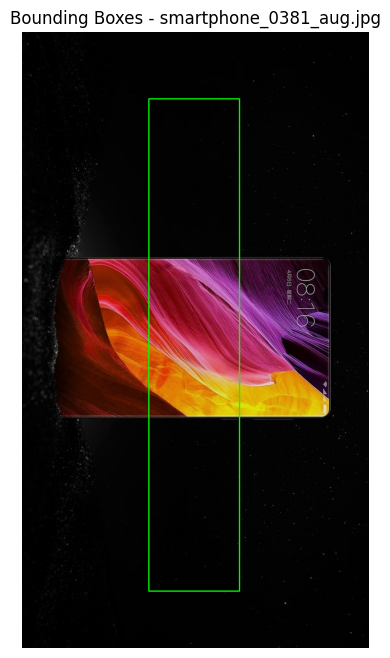

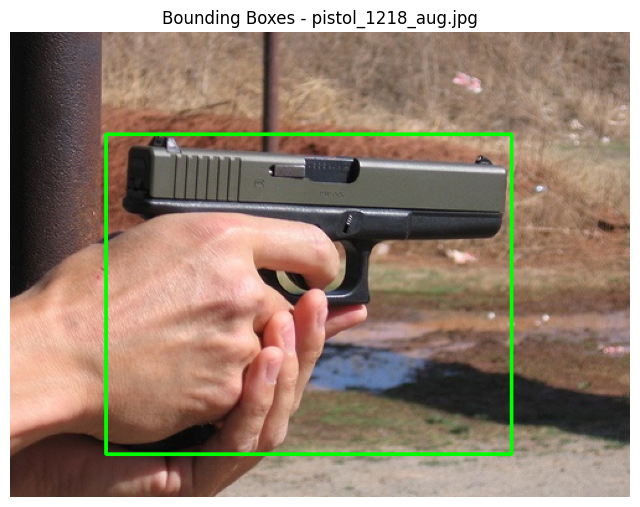

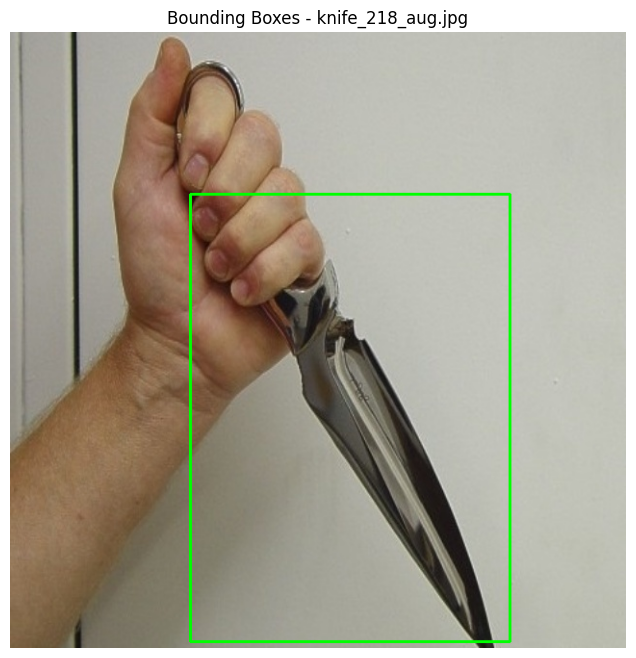

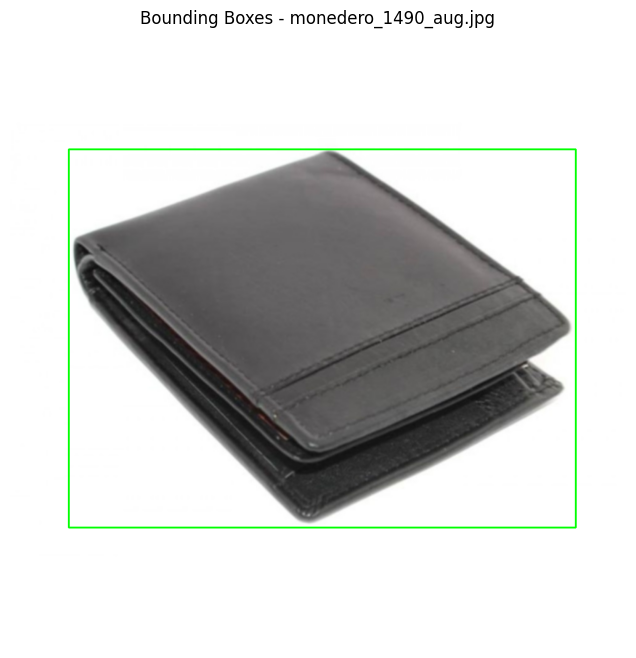

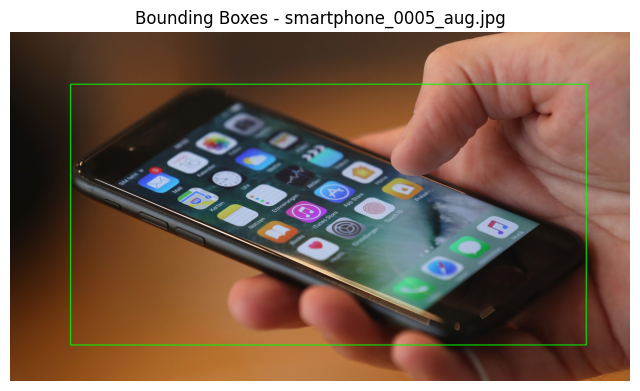

In [6]:
import cv2
import os
import matplotlib.pyplot as plt

# Función para leer las etiquetas en formato YOLO
def read_yolo_labels(label_path):
    boxes = []
    with open(label_path, "r") as file:
        for line in file.readlines():
            values = line.strip().split()
            class_id = int(values[0])  # Clase
            x_center, y_center, width, height = map(float, values[1:])
            boxes.append((class_id, x_center, y_center, width, height))
    return boxes

# Función para dibujar bounding boxes en la imagen
def draw_bounding_boxes(image, boxes, image_size):
    h, w, _ = image_size
    for class_id, x_center, y_center, width, height in boxes:
        # Convertir coordenadas de YOLO a coordenadas de OpenCV
        x1 = int((x_center - width / 2) * w)
        y1 = int((y_center - height / 2) * h)
        x2 = int((x_center + width / 2) * w)
        y2 = int((y_center + height / 2) * h)

        # Dibujar la caja en la imagen
        color = (0, 255, 0)  # Verde
        thickness = 2
        cv2.rectangle(image, (x1, y1), (x2, y2), color, thickness)

    return image

# Función principal
def visualize_annotations(image_folder, label_folder, num_images=5):
    image_files = [f for f in os.listdir(image_folder) if f.endswith("_aug.jpg") or f.endswith("_aug.png")]
    
    # Seleccionar un subconjunto de imágenes
    image_files = image_files[:num_images]

    for image_name in image_files:
        img_path = os.path.join(image_folder, image_name)
        label_path = os.path.join(label_folder, image_name.replace(".jpg", ".txt").replace(".png", ".txt"))

        # Cargar imagen
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if not os.path.exists(label_path):
            print(f"⚠️ No se encontró la etiqueta para {image_name}")
            continue

        # Leer etiquetas YOLO
        boxes = read_yolo_labels(label_path)

        # Dibujar las bounding boxes
        image_with_boxes = draw_bounding_boxes(image, boxes, image.shape)

        # Mostrar la imagen con las BB
        plt.figure(figsize=(8, 8))
        plt.imshow(image_with_boxes)
        plt.title(f"Bounding Boxes - {image_name}")
        plt.axis("off")
        plt.show()

# 🔹 Ejecutar con las rutas adecuadas
image_folder = "/mnt/homeGPU/azapata/TFG/datasets/gunsUGR/OD-WeaponDetection-master/Weapons_and_similar_handled_objects/Sohas_weapon-Detection-YOLOv5/obj_train_data/weapons_DA_classic/images"
label_folder = "/mnt/homeGPU/azapata/TFG/datasets/gunsUGR/OD-WeaponDetection-master/Weapons_and_similar_handled_objects/Sohas_weapon-Detection-YOLOv5/obj_train_data/weapons_DA_classic/labels"

visualize_annotations(image_folder, label_folder, num_images=5)  # Cambia el número de imágenes si quieres visualizar más


Efectivamente, las imagenes no se han alineado correctamente. En lugar de hacer "a mano" el DA vamos a utiliazr DA del propio YOLOv8 para evitar esto y además evitar así tener que crear un dataset nuevo. Modificamos el script de entrenamiento de YOLO finetuning DA clasico y eliminamos el generador manual.

---
Comprobamos que el dataset de DM este bien

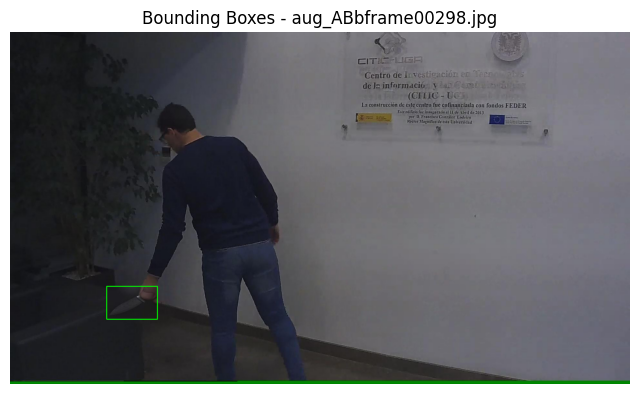

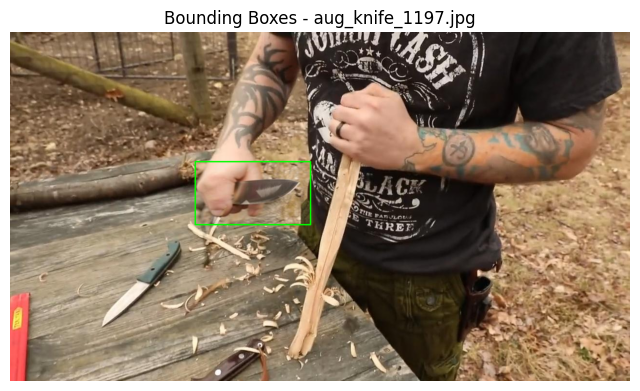

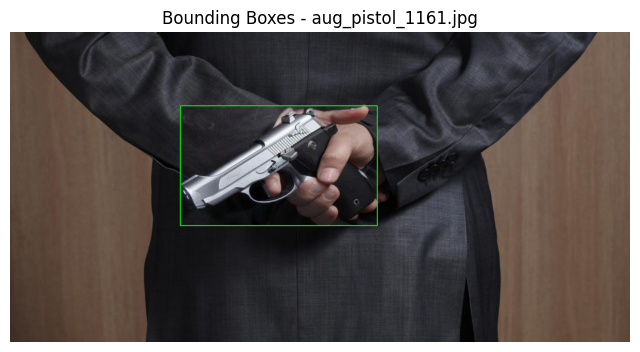

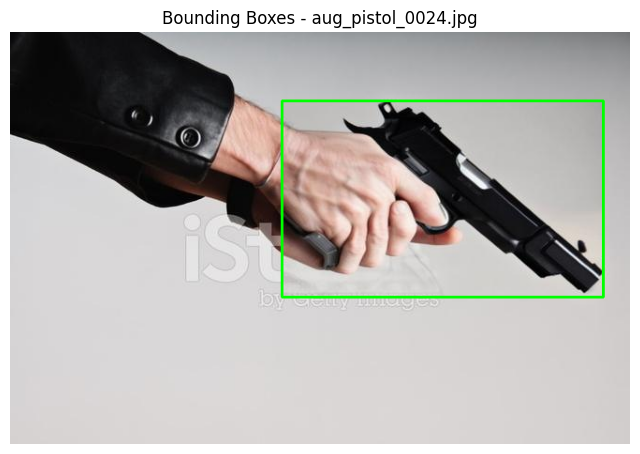

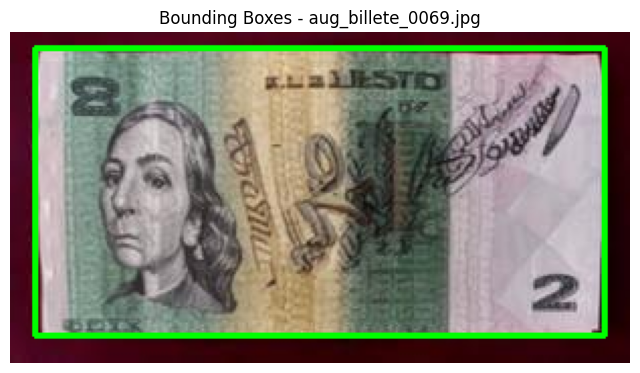

In [ ]:
image_folder = "/mnt/homeGPU/azapata/TFG/datasets/gunsUGR/OD-WeaponDetection-master/Weapons_and_similar_handled_objects/Sohas_weapon-Detection-YOLOv5/obj_train_data/weapons_DM/images"
label_folder = "/mnt/homeGPU/azapata/TFG/datasets/gunsUGR/OD-WeaponDetection-master/Weapons_and_similar_handled_objects/Sohas_weapon-Detection-YOLOv5/obj_train_data/weapons_DM/labels"

visualize_annotations(image_folder, label_folder, num_images=5)  # Cambia el número de imágenes si quieres visualizar más


Ahora el dataset weapons_DM contiene 9831 imagenes, mientras que el original 5002, por lo que se generan 4829 imagenes con DM

---
# Resultados de finetuning sin DA

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 
                   all        857        857      0.848      0.789      0.886       0.73
                pistol         85         85       0.91      0.918      0.952      0.783
            smartphone        140        140      0.939      0.663      0.922      0.801
                 knife        452        452       0.97      0.903      0.973      0.676
              monedero         71         71      0.642      0.789      0.762       0.63
               billete         52         52      0.851      0.885      0.926      0.823
               tarjeta         57         57      0.777      0.579      0.782      0.665

---
# Resultado de DA Clásico
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 
                   all        857        857      0.791      0.819       0.89      0.741
                pistol         85         85      0.812      0.917       0.94      0.777
            smartphone        140        140      0.868      0.753      0.924      0.802
                 knife        452        452      0.944      0.954      0.983      0.702
              monedero         71         71      0.623      0.792      0.797      0.688
               billete         52         52      0.735      0.923       0.93      0.827
               tarjeta         57         57      0.766      0.574      0.766      0.653

Vemos que empeora un poco respecto al original, por lo que DA clásico no es efectivo para este dataset en concreto (o al menos el que se le hizo)



----
# Resultados DA DM
               Class     Images  Instances      Box(P          R      mAP50  mAP50-95):
                   all        857        857      0.839      0.839      0.903      0.757
                pistol         85         85      0.871      0.871      0.943      0.789
            smartphone        140        140      0.957      0.804       0.94      0.812
                 knife        452        452      0.965      0.938      0.979      0.705
              monedero         71         71      0.708       0.82      0.812      0.712
               billete         52         52      0.773      0.885      0.935      0.847
               tarjeta         57         57      0.758      0.714      0.811      0.679

# Resultados DA hibrido

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 
                   all        857        857      0.868      0.839      0.911      0.769
                pistol         85         85      0.871      0.918      0.942      0.797
            smartphone        140        140      0.982       0.75      0.948      0.819
                 knife        452        452      0.975      0.932      0.984      0.715
              monedero         71         71      0.704      0.817      0.791      0.691
               billete         52         52      0.874      0.904      0.961      0.869
               tarjeta         57         57      0.803      0.716      0.841      0.721